In [1]:
import numpy as np

In [9]:
import pandas as pd
import seaborn as sns

In [3]:
df=pd.read_csv('gurgaon_properties_post_feature_selection.csv')

In [4]:
df.head()

,property_type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category,price
0,0.0,16.0,3.0,5.0,2.0,3.0,2800.0,1,0,0,2.0,2.0,3.65
1,0.0,95.0,4.0,4.0,3.0,0.0,1970.0,1,0,0,2.0,0.0,1.25
2,0.0,103.0,2.0,2.0,1.0,1.0,767.0,0,0,0,1.0,1.0,0.47
3,0.0,55.0,3.0,3.0,3.0,2.0,1600.0,0,0,2,1.0,1.0,1.90
4,0.0,89.0,3.0,4.0,4.0,1.0,2152.0,1,0,0,1.0,2.0,2.69


In [5]:
X = df.drop(columns=['price'])
y = df['price']

In [58]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR

In [44]:
columns_to_encode = ['sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']
categorical_features = ['property_type'] + columns_to_encode

<Axes: xlabel='price', ylabel='Count'>

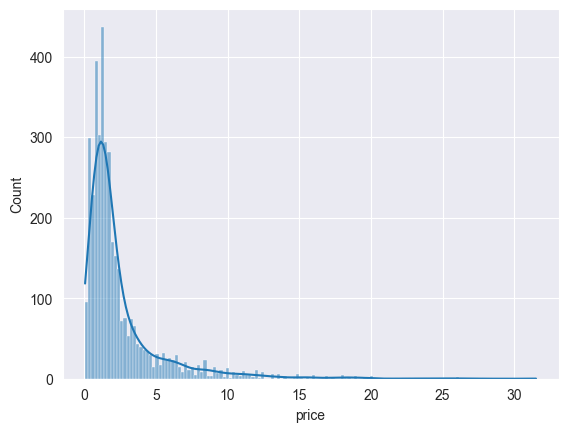

In [10]:
sns.histplot(y,kde=True)

In [11]:
y_transformed = np.log1p(y)

<Axes: xlabel='price', ylabel='Count'>

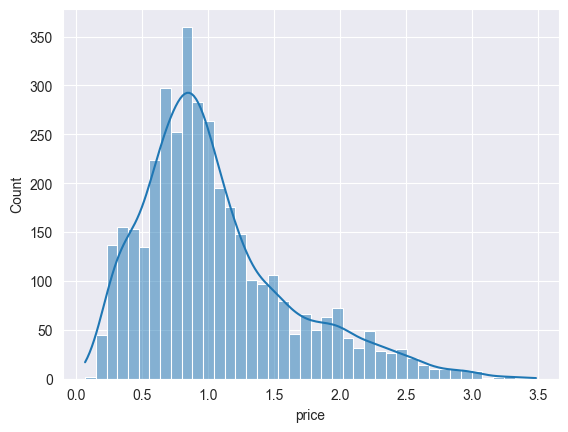

In [13]:
sns.histplot(y_transformed,kde=True)

In [47]:
# Creating a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), [ 'bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OneHotEncoder(drop='first',handle_unknown='ignore',sparse_output=False), categorical_features)
    ],
    remainder='passthrough'

)

In [68]:
# Creating a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),

    ('regressor', SVR(kernel='rbf'))
])

In [69]:
# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y_transformed, cv=kfold, scoring='r2')
print(scores)



C:\Users\RAHUL\PycharmProjects\capstone\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[0.850204   0.88329065 0.84487283 0.75576496 0.77568117 0.84694955
 0.79679076 0.77756772 0.80216098 0.85364101]


In [23]:
import numpy as np

y_dense = np.ravel(y_transformed.toarray()) if hasattr(y_transformed, 'toarray') else np.ravel(y_transformed)


In [33]:
from sklearn.preprocessing import FunctionTransformer
make_dense = FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)

In [39]:
print(X.shape,type(X))



(3802, 12) <class 'pandas.core.frame.DataFrame'>


In [40]:
print(type(y_transformed), y_transformed.shape)

<class 'pandas.core.series.Series'> (3802,)


##### error i faced above took my most of the time to debug and that was in onehot encoding
##### a test split included a category that was not present in train split.
##### so i did handle_unknown="ignore" it didnt crash instead it encoded the unknown category as a zero vecotr and then raised a warning

In [70]:
scores.mean()

0.8186923631260348

In [71]:
scores.std()

0.04015624478264342

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_transformed,test_size=0.2,random_state=42)

In [73]:
pipeline.fit(X_train,y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [74]:
y_pred = pipeline.predict(X_test)

In [75]:
y_pred = np.expm1(y_pred) # above i log tranformed y label so i am taking exponent here

In [76]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(np.expm1(y_test),y_pred)

0.615548351632217